People always look at a player's performance over the past season or several as an indicator of his skills. But how accurate is it actually at predicting the same player's performance in the new season? How many seasons back should be look? And how much the player's team can affect it? Those are the main topics this notebook aims to research.

At first, we are going to test out a simple model where we are only interested in the points (goals + assists) and, therefore, only the skaters. If the model shows any promising result, we can attempt expanding it to the other key performance indicators as well.

In [37]:
# Importing standard packages for data exploration and processing.
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


# We do not need the whole dataframe.
columns_read = ['Profile', 'Player', 'Season', 'Team', 'Year', 'Games', 'Points', 'Icetime_game_seconds']
data = pd.read_csv('../data/players/skaters_season.csv', usecols=columns_read)
data.head()

,Profile,Player,Season,Year,Team,Games,Points,Icetime_game_seconds
0,https://en.khl.ru/players/16673/,Sergei Abramov,Regular season,2014/2015,Amur (Khabarovsk),13,1,417
1,https://en.khl.ru/players/16673/,Sergei Abramov,Regular season,2013/2014,Amur (Khabarovsk),12,0,375
2,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2017/2018,Dinamo (Minsk),8,0,360
3,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2016/2017,Dinamo (Minsk),20,4,583
4,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2015/2016,Dinamo (Minsk),11,1,283


We will definitely need the total time on ice over the season. After all, two players might be equally skilled but one of them simply gets much more icetime and thus gets more points. What we are going to use is not the points over the season but really a standartised amount of points over a certain interval. For ease of browse, let us set the interval as 60 minutes (standard match length) the same as with goalies.

In [38]:
data['Icetime'] = data['Games'] * data['Icetime_game_seconds'] / 3600
data['Points_average'] = data['Points'] / data['Icetime']
data.head()

,Profile,Player,Season,Year,Team,Games,Points,Icetime_game_seconds,Icetime,Points_average
0,https://en.khl.ru/players/16673/,Sergei Abramov,Regular season,2014/2015,Amur (Khabarovsk),13,1,417,1.505833,0.664084
1,https://en.khl.ru/players/16673/,Sergei Abramov,Regular season,2013/2014,Amur (Khabarovsk),12,0,375,1.250000,0.000000
2,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2017/2018,Dinamo (Minsk),8,0,360,0.800000,0.000000
3,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2016/2017,Dinamo (Minsk),20,4,583,3.238889,1.234991
4,https://en.khl.ru/players/19200/,Dmitry Ambrozheichik,Regular season,2015/2016,Dinamo (Minsk),11,1,283,0.864722,1.156441


Since we are using averages we need to ensure that all players have participated at a certain bare mininum during the season. Otherwise, their results that season are not accurate enough to base any predictions off. They are also subject to a lot of fluctuation that would end up getting accredited to other factors.

This could be accounted for in several ways, based off either games played, points scored or icetime recorded. We are going to use all three. Let us set the minimum requirement at 30 games, 10 minutes of icetime per game and 10 points.

On a related note, let us drop all playoff seasons from the data. Not only they tend to be fairly short and would be mostly sorted out based on the icetime required, but the playoff matches tend to behave somewhat differently than the regular season.

In [39]:
data = data[data['Season'] == 'Regular season']
data = data[data['Games'] >= 30]
data = data[data['Icetime_game_seconds'] >= 600]
data = data[data['Points'] >= 10]

In [40]:
data.describe()

,Games,Points,Icetime_game_seconds,Icetime,Points_average
count,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000
mean,48.821652,22.016688,1003.364622,13.674114,1.626762
std,7.585640,10.798156,173.329671,3.435627,0.661923
min,30.000000,10.000000,600.000000,5.287222,0.447094
25%,44.000000,14.000000,878.000000,11.158472,1.123944
50%,50.000000,19.000000,996.000000,13.555556,1.530128
75%,54.000000,27.000000,1119.750000,15.978472,2.016524
max,63.000000,85.000000,1720.000000,26.500000,5.162264


Important note! We have some rows where Team is specified as "Summary:". That is the case when a player has changed his team during the season, so he ends up having a separate row of statistics for both teams and for them combined.

Ideally, we want to take such cases into account but it present problems of its own. If we keep just the summary, we cannot include teams in our model. If we keep the statistics for each team separately, the rows might fail the icetime requirement even if the player had enough icetime that season to get included. For now, let us go with the latter approach.

In [44]:
data = data[data['Team'] != 'Summary']

In [45]:
data.groupby('Team').mean()

,Games,Points,Icetime_game_seconds,Icetime,Points_average
Team,,,,,
Admiral (Vladivostok),49.764045,20.191011,996.123596,13.819042,1.482703
Ak Bars (Kazan),49.359375,23.890625,990.005208,13.640472,1.767149
Amur (Khabarovsk),49.251613,19.122581,1013.832258,13.924505,1.399963
Atlant (Moscow Region),49.220930,22.906977,1004.720930,13.787251,1.678051
Avangard (Omsk),49.742690,23.654971,1026.005848,14.259246,1.688108
Avtomobilist (Ekaterinburg),48.938776,21.863946,1014.394558,13.882591,1.589958
Barys (Nur-Sultan),49.994318,25.840909,1045.392045,14.636765,1.774046
CSKA (Moscow),46.801075,23.279570,991.048387,12.928944,1.812844
Dinamo (Minsk),48.337838,23.101351,1059.155405,14.214908,1.630239


We are going to first try predicting based off the latest two seasons that player has participated in. Important note - those seasons are not necessarily the last ones as a player could not participate in some seasons or not participate enough to be included in our analysis. And since we need the values for at least the current and two latest seasons for each player, players with less than 3 seasons in the data have to be dropped altogether.

In [8]:
data = data.groupby('Profile').filter(lambda x: len(x) > 2)

In [9]:
# To avoid typing column lists manually.
data.columns

Index(['Profile', 'Player', 'Season', 'Year', 'Team', 'Games', 'Points',
       'Icetime_game_seconds', 'Icetime', 'Points_average'],
      dtype='object')

In [10]:
# We can drop all unnecessary columns now.
drop_list = ['Season', 'Games', 'Points', 'Icetime_game_seconds', 'Icetime']
data.drop(drop_list, axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)
data.head()

,Profile,Player,Year,Team,Points_average
0,https://en.khl.ru/players/3989/,Vitaly Atyushov,2010/2011,Metallurg (Magnitogorsk),1.145002
1,https://en.khl.ru/players/3989/,Vitaly Atyushov,2009/2010,Metallurg (Magnitogorsk),1.239514
2,https://en.khl.ru/players/3989/,Vitaly Atyushov,2008/2009,Metallurg (Magnitogorsk),1.685731
3,https://en.khl.ru/players/14597/,Yegor Averin,2018/2019,Lokomotiv (Yaroslavl),1.679044
4,https://en.khl.ru/players/14597/,Yegor Averin,2017/2018,Lokomotiv (Yaroslavl),1.500341


We now need to add the year/team/points data from the past two years to the dataframe. The simplest way to do this is by adding shifted versions of the same columns with different column names. However, a row above does not necessarily contain the data for the same player. To account for that, we are going to include both past profile and player name in the output dataframe and check that they remain the same.

In [11]:
# The rows are going to be shifted down.
# All columns are getting a T_ prefix indicating their timeshift relative to the current period.
header = ['T0_Profile', 'T0_Player', 'T0_Year', 'T0_Team', 'T0_Points']
header_1 = ['T1_Profile', 'T1_Player', 'T1_Year', 'T1_Team', 'T1_Points']
header_2 = ['T2_Profile', 'T2_Player', 'T2_Year', 'T2_Team', 'T2_Points']

data.columns = header
data[header_1] = data[header].shift(-1)
data[header_2] = data[header].shift(-2)
data.head()

,T0_Profile,T0_Player,T0_Year,T0_Team,T0_Points,T1_Profile,T1_Player,T1_Year,T1_Team,T1_Points,T2_Profile,T2_Player,T2_Year,T2_Team,T2_Points
0,https://en.khl.ru/players/3989/,Vitaly Atyushov,2010/2011,Metallurg (Magnitogorsk),1.145002,https://en.khl.ru/players/3989/,Vitaly Atyushov,2009/2010,Metallurg (Magnitogorsk),1.239514,https://en.khl.ru/players/3989/,Vitaly Atyushov,2008/2009,Metallurg (Magnitogorsk),1.685731
1,https://en.khl.ru/players/3989/,Vitaly Atyushov,2009/2010,Metallurg (Magnitogorsk),1.239514,https://en.khl.ru/players/3989/,Vitaly Atyushov,2008/2009,Metallurg (Magnitogorsk),1.685731,https://en.khl.ru/players/14597/,Yegor Averin,2018/2019,Lokomotiv (Yaroslavl),1.679044
2,https://en.khl.ru/players/3989/,Vitaly Atyushov,2008/2009,Metallurg (Magnitogorsk),1.685731,https://en.khl.ru/players/14597/,Yegor Averin,2018/2019,Lokomotiv (Yaroslavl),1.679044,https://en.khl.ru/players/14597/,Yegor Averin,2017/2018,Lokomotiv (Yaroslavl),1.500341
3,https://en.khl.ru/players/14597/,Yegor Averin,2018/2019,Lokomotiv (Yaroslavl),1.679044,https://en.khl.ru/players/14597/,Yegor Averin,2017/2018,Lokomotiv (Yaroslavl),1.500341,https://en.khl.ru/players/14597/,Yegor Averin,2015/2016,Lokomotiv (Yaroslavl),2.666228
4,https://en.khl.ru/players/14597/,Yegor Averin,2017/2018,Lokomotiv (Yaroslavl),1.500341,https://en.khl.ru/players/14597/,Yegor Averin,2015/2016,Lokomotiv (Yaroslavl),2.666228,https://en.khl.ru/players/14597/,Yegor Averin,2014/2015,Lokomotiv (Yaroslavl),2.141961


In [12]:
data.tail(5)

,T0_Profile,T0_Player,T0_Year,T0_Team,T0_Points,T1_Profile,T1_Player,T1_Year,T1_Team,T1_Points,T2_Profile,T2_Player,T2_Year,T2_Team,T2_Points
1374,https://en.khl.ru/players/19641/,Tomas Zohorna,2016/2017,Amur (Khabarovsk),1.802412,https://en.khl.ru/players/19641/,Tomas Zohorna,2015/2016,Amur (Khabarovsk),1.462671,https://en.khl.ru/players/23355/,Denis Zernov,2020/2021,Avangard (Omsk),2.456499
1375,https://en.khl.ru/players/19641/,Tomas Zohorna,2015/2016,Amur (Khabarovsk),1.462671,https://en.khl.ru/players/23355/,Denis Zernov,2020/2021,Avangard (Omsk),2.456499,https://en.khl.ru/players/23355/,Denis Zernov,2018/2019,Avangard (Omsk),1.911462
1376,https://en.khl.ru/players/23355/,Denis Zernov,2020/2021,Avangard (Omsk),2.456499,https://en.khl.ru/players/23355/,Denis Zernov,2018/2019,Avangard (Omsk),1.911462,https://en.khl.ru/players/23355/,Denis Zernov,2017/2018,Lada (Togliatti),1.615499
1377,https://en.khl.ru/players/23355/,Denis Zernov,2018/2019,Avangard (Omsk),1.911462,https://en.khl.ru/players/23355/,Denis Zernov,2017/2018,Lada (Togliatti),1.615499,NaN,NaN,NaN,NaN,NaN
1378,https://en.khl.ru/players/23355/,Denis Zernov,2017/2018,Lada (Togliatti),1.615499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We are also encountering another issue here. Since some players have changed teams during the season, we are getting observations where the last time period our of three would be season 2009/2010. And, what is worse, some players have even played for three teams in season 2008/2009. Not only do those seasons have few observations, they are not representative as only the players who have changed teams can have either of their seasons as the latest of the three. Therefore, let us drop them.

In [13]:
# Now dropping the rows which contain data for different players in them.
data = data[(data['T0_Profile'] == data['T1_Profile']) & (data['T0_Profile'] == data['T2_Profile'])]
data = data[(data['T0_Year'] != '2008/2009') & (data['T0_Year'] != '2009/2010')]
data.reset_index(drop=True, inplace=True)
data.head()

,T0_Profile,T0_Player,T0_Year,T0_Team,T0_Points,T1_Profile,T1_Player,T1_Year,T1_Team,T1_Points,T2_Profile,T2_Player,T2_Year,T2_Team,T2_Points
0,https://en.khl.ru/players/3989/,Vitaly Atyushov,2010/2011,Metallurg (Magnitogorsk),1.145002,https://en.khl.ru/players/3989/,Vitaly Atyushov,2009/2010,Metallurg (Magnitogorsk),1.239514,https://en.khl.ru/players/3989/,Vitaly Atyushov,2008/2009,Metallurg (Magnitogorsk),1.685731
1,https://en.khl.ru/players/14597/,Yegor Averin,2018/2019,Lokomotiv (Yaroslavl),1.679044,https://en.khl.ru/players/14597/,Yegor Averin,2017/2018,Lokomotiv (Yaroslavl),1.500341,https://en.khl.ru/players/14597/,Yegor Averin,2015/2016,Lokomotiv (Yaroslavl),2.666228
2,https://en.khl.ru/players/14597/,Yegor Averin,2017/2018,Lokomotiv (Yaroslavl),1.500341,https://en.khl.ru/players/14597/,Yegor Averin,2015/2016,Lokomotiv (Yaroslavl),2.666228,https://en.khl.ru/players/14597/,Yegor Averin,2014/2015,Lokomotiv (Yaroslavl),2.141961
3,https://en.khl.ru/players/14597/,Yegor Averin,2015/2016,Lokomotiv (Yaroslavl),2.666228,https://en.khl.ru/players/14597/,Yegor Averin,2014/2015,Lokomotiv (Yaroslavl),2.141961,https://en.khl.ru/players/14597/,Yegor Averin,2013/2014,Lokomotiv (Yaroslavl),1.571709
4,https://en.khl.ru/players/15999/,Viktor Antipin,2018/2019,Metallurg (Magnitogorsk),1.301379,https://en.khl.ru/players/15999/,Viktor Antipin,2016/2017,Metallurg (Magnitogorsk),1.111083,https://en.khl.ru/players/15999/,Viktor Antipin,2014/2015,Metallurg (Magnitogorsk),1.117318


In [14]:
# Everything seems in order, we can drop the duplicate columns now.
data.drop(['T1_Profile', 'T1_Player', 'T2_Profile', 'T2_Player'], axis=1, inplace=True)
data.head()

,T0_Profile,T0_Player,T0_Year,T0_Team,T0_Points,T1_Year,T1_Team,T1_Points,T2_Year,T2_Team,T2_Points
0,https://en.khl.ru/players/3989/,Vitaly Atyushov,2010/2011,Metallurg (Magnitogorsk),1.145002,2009/2010,Metallurg (Magnitogorsk),1.239514,2008/2009,Metallurg (Magnitogorsk),1.685731
1,https://en.khl.ru/players/14597/,Yegor Averin,2018/2019,Lokomotiv (Yaroslavl),1.679044,2017/2018,Lokomotiv (Yaroslavl),1.500341,2015/2016,Lokomotiv (Yaroslavl),2.666228
2,https://en.khl.ru/players/14597/,Yegor Averin,2017/2018,Lokomotiv (Yaroslavl),1.500341,2015/2016,Lokomotiv (Yaroslavl),2.666228,2014/2015,Lokomotiv (Yaroslavl),2.141961
3,https://en.khl.ru/players/14597/,Yegor Averin,2015/2016,Lokomotiv (Yaroslavl),2.666228,2014/2015,Lokomotiv (Yaroslavl),2.141961,2013/2014,Lokomotiv (Yaroslavl),1.571709
4,https://en.khl.ru/players/15999/,Viktor Antipin,2018/2019,Metallurg (Magnitogorsk),1.301379,2016/2017,Metallurg (Magnitogorsk),1.111083,2014/2015,Metallurg (Magnitogorsk),1.117318


In [15]:
# We can now get dummies for our years and teams.
dummies = data.copy()
dummies.drop(['T0_Profile', 'T0_Player'], axis=1, inplace=True)
dummies = pd.get_dummies(dummies, drop_first=True)
dummies.head()

,T0_Points,T1_Points,T2_Points,T0_Year_2011/2012,T0_Year_2012/2013,T0_Year_2013/2014,T0_Year_2014/2015,T0_Year_2015/2016,T0_Year_2016/2017,T0_Year_2017/2018,T0_Year_2018/2019,T0_Year_2019/2020,T0_Year_2020/2021,T0_Team_Ak Bars (Kazan),T0_Team_Amur (Khabarovsk),T0_Team_Atlant (Moscow Region),T0_Team_Avangard (Omsk),T0_Team_Avtomobilist (Ekaterinburg),T0_Team_Barys (Nur-Sultan),T0_Team_CSKA (Moscow),T0_Team_Dinamo (Minsk),T0_Team_Dinamo (Riga),T0_Team_Donbass (Donetsk),T0_Team_Dynamo (Moscow),T0_Team_Jokerit (Helsinki),T0_Team_Kunlun Red Star (Beijing),T0_Team_Lada (Togliatti),T0_Team_Lev (Praha),T0_Team_Lokomotiv (Yaroslavl),T0_Team_Medvescak (Zagreb),T0_Team_Metallurg (Magnitogorsk),T0_Team_Metallurg (Novokuznetsk),T0_Team_Neftekhimik (Nizhnekamsk),T0_Team_SKA (Saint Petersburg),T0_Team_Salavat Yulaev (Ufa),T0_Team_Severstal (Cherepovets),T0_Team_Sibir (Novosibirsk Region),T0_Team_Slovan (Bratislava),T0_Team_Sochi (Sochi),T0_Team_Spartak (Moscow),T0_Team_Summary,T0_Team_Torpedo (Nizhny Novgorod Region),T0_Team_Traktor (Chelyabinsk),T0_Team_Ugra (Khanty-Mansiysk),T0_Team_Vityaz (Moscow Region),T1_Year_2009/2010,T1_Year_2010/2011,T1_Year_2011/2012,T1_Year_2012/2013,T1_Year_2013/2014,T1_Year_2014/2015,T1_Year_2015/2016,T1_Year_2016/2017,T1_Year_2017/2018,T1_Year_2018/2019,T1_Year_2019/2020,T1_Team_Ak Bars (Kazan),T1_Team_Amur (Khabarovsk),T1_Team_Atlant (Moscow Region),T1_Team_Avangard (Omsk),T1_Team_Avtomobilist (Ekaterinburg),T1_Team_Barys (Nur-Sultan),T1_Team_CSKA (Moscow),T1_Team_Dinamo (Minsk),T1_Team_Dinamo (Riga),T1_Team_Donbass (Donetsk),T1_Team_Dynamo (Moscow),T1_Team_HC MVD (Moscow Region),T1_Team_Jokerit (Helsinki),T1_Team_Kunlun Red Star (Beijing),T1_Team_Lada (Togliatti),T1_Team_Lev (Praha),T1_Team_Lokomotiv (Yaroslavl),T1_Team_Medvescak (Zagreb),T1_Team_Metallurg (Magnitogorsk),T1_Team_Metallurg (Novokuznetsk),T1_Team_Neftekhimik (Nizhnekamsk),T1_Team_SKA (Saint Petersburg),T1_Team_Salavat Yulaev (Ufa),T1_Team_Severstal (Cherepovets),T1_Team_Sibir (Novosibirsk Region),T1_Team_Slovan (Bratislava),T1_Team_Sochi (Sochi),T1_Team_Spartak (Moscow),T1_Team_Summary,T1_Team_Torpedo (Nizhny Novgorod Region),T1_Team_Traktor (Chelyabinsk),T1_Team_Ugra (Khanty-Mansiysk),T1_Team_Vityaz (Moscow Region),T2_Year_2009/2010,T2_Year_2010/2011,T2_Year_2011/2012,T2_Year_2012/2013,T2_Year_2013/2014,T2_Year_2014/2015,T2_Year_2015/2016,T2_Year_2016/2017,T2_Year_2017/2018,T2_Year_2018/2019,T2_Year_2019/2020,T2_Team_Ak Bars (Kazan),T2_Team_Amur (Khabarovsk),T2_Team_Atlant (Moscow Region),T2_Team_Avangard (Omsk),T2_Team_Avtomobilist (Ekaterinburg),T2_Team_Barys (Nur-Sultan),T2_Team_CSKA (Moscow),T2_Team_Dinamo (Minsk),T2_Team_Dinamo (Riga),T2_Team_Donbass (Donetsk),T2_Team_Dynamo (Moscow),T2_Team_HC MVD (Moscow Region),T2_Team_Jokerit (Helsinki),T2_Team_Kunlun Red Star (Beijing),T2_Team_Lada (Togliatti),T2_Team_Lev (Poprad),T2_Team_Lev (Praha),T2_Team_Lokomotiv (Yaroslavl),T2_Team_Medvescak (Zagreb),T2_Team_Metallurg (Magnitogorsk),T2_Team_Metallurg (Novokuznetsk),T2_Team_Neftekhimik (Nizhnekamsk),T2_Team_SKA (Saint Petersburg),T2_Team_Salavat Yulaev (Ufa),T2_Team_Severstal (Cherepovets),T2_Team_Sibir (Novosibirsk Region),T2_Team_Slovan (Bratislava),T2_Team_Sochi (Sochi),T2_Team_Spartak (Moscow),T2_Team_Summary,T2_Team_Torpedo (Nizhny Novgorod Region),T2_Team_Traktor (Chelyabinsk),T2_Team_Ugra (Khanty-Mansiysk),T2_Team_Vityaz (Moscow Region)
0,1.145002,1.239514,1.685731,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.679044,1.500341,2.666228,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.500341,2.666228,2.141961,0,

We can now try fitting Machine Learning models on that prepared data. Let us first start with a simple linear regression before moving to random forests and boosted trees.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# We are trying to predict how many points a player gets this new season based off everything else.
y = dummies['T0_Points'].copy()
X = dummies.drop('T0_Points', axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
linear = LinearRegression(n_jobs=-1)

In [20]:
linear.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [21]:
y_pred = linear.predict(X_test)

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [23]:
y_train.mean()

2.160765712563227

In [24]:
y_test.mean()

2.134796591118245

In [25]:
y_pred.mean()

2.1404074545432006

In [26]:
mean_squared_error(y_test, y_pred)

0.29562761398308857

In [27]:
mean_absolute_error(y_test, y_pred)

0.4270938459788381

In [28]:
r2_score(y_test, y_pred)

0.226031636958139

In [29]:
# Getting coefficients in a more readable form.
linear_coef = pd.DataFrame(zip(X.columns, linear.coef_))
linear_coef.columns = ['Feature', 'Coefficient']
linear_coef

,Feature,Coefficient
0,T1_Points,0.383922
1,T2_Points,0.296542
2,T0_Year_2011/2012,0.087064
3,T0_Year_2012/2013,0.180140
4,T0_Year_2013/2014,0.132019
5,T0_Year_2014/2015,0.276117
6,T0_Year_2015/2016,-0.104153
7,T0_Year_2016/2017,-0.046732
8,T0_Year_2017/2018,-0.275135
9,T0_Year_2018/2019,-0.341122


We can still improve on the way coefficients are stored. After all, we have 3 sets of coefficients for three different time periods. Why not give each period its own column?

In [30]:
# Splitting the dataframe into three.
T0_coef = linear_coef[linear_coef['Feature'].str.startswith('T0_')].copy().reset_index(drop=True)
T1_coef = linear_coef[linear_coef['Feature'].str.startswith('T1_')].copy().reset_index(drop=True)
T2_coef = linear_coef[linear_coef['Feature'].str.startswith('T2_')].copy().reset_index(drop=True)

# Removing the year indicators from feature names.
T0_coef['Feature'].replace({'T0_': ''}, inplace=True, regex=True)
T1_coef['Feature'].replace({'T1_': ''}, inplace=True, regex=True)
T2_coef['Feature'].replace({'T2_': ''}, inplace=True, regex=True)

# Changing column names for coefficients.
T0_coef.columns = ['Feature', 'Period_0']
T1_coef.columns = ['Feature', 'Period_1']
T2_coef.columns = ['Feature', 'Period_2']

# Final dataframe.
linear_coef = T0_coef.merge(T1_coef, how='outer', on='Feature').merge(T2_coef, how='outer', on='Feature')
linear_coef

,Feature,Period_0,Period_1,Period_2
0,Year_2011/2012,0.087064,0.530902,0.174073
1,Year_2012/2013,0.180140,0.291117,-0.004679
2,Year_2013/2014,0.132019,0.508798,0.296976
3,Year_2014/2015,0.276117,0.519400,0.221828
4,Year_2015/2016,-0.104153,0.675372,0.258486
5,Year_2016/2017,-0.046732,0.760695,0.400588
6,Year_2017/2018,-0.275135,0.625347,0.454562
7,Year_2018/2019,-0.341122,0.593989,0.806204
8,Year_2019/2020,-0.487264,0.521173,0.530271
9,Year_2020/2021,-0.463558,NaN,NaN


We will need to rearrange the columns for sure. More importantly, why are Period 1 year features' coefficients so high? Something is definitely not right in here.

In [32]:
import matplotlib.pyplot as plt

[]

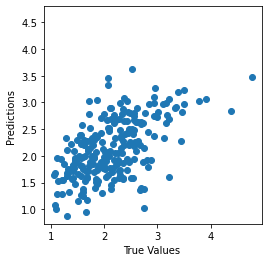

In [34]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.plot()